The <B>Simple Morphological Filter</B> or <b>SMRF</b> is a progressive filter that uses morphpological opening to identify which points in a cloud are objects (1) or ground (0).  The filter returns a provisional ground surface, a rasterio-style affine matrix, a boolean raster identifying object/ground in the raster, and a vector identifying object/ground for each point.

The filter takes five parameters in addition to x,y,z data:
1) cellsize: The resolution of the raster, in input units
2) windows: The number of windows or maximum window sizes in pixels.  An array explicitly defining windows may also be passed.
3) slope_threshold: The key parameter that is used to flag object cells at each iteration (.15 is 15 percent) 

If the original points in the cloud are to be identified as object/ground, the last two parameters are also necessary:
4) elevation_threshold: A parameter used to classify point cloud data from the estimated ground surface (in input units)
5) elevation_scaler: A parameter used to apply a more lenient elevation threshold on steep slopes (a multiplier, often near 1)

SMRF was tested against the <a target="_blank" href="http://www.itc.nl/isprswgIII-3/filtertest/StartPage.htm">ISPRS LIDAR reference data set</a>, assembled by <a target="_blank" href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.155.1855&rep=rep1&type=pdf">Sithole and Vosselman (2003)</a>. It achieved a mean total error rate of 2.97% and a mean Cohen's Kappa score of 90.02%.

Pingel, T. J., Clarke K. C., & McBride, W. A. (2013). An Improved Simple Morphological Filter for the Terrain Classification of Airborne LIDAR Data. ISPRS Journal of Photogrammetry and Remote Sensing, 77, 31-30. http://dx.doi.org/10.1016/j.isprsjprs.2012.12.002

In [1]:
import neilpy

import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

%matplotlib notebook

<IPython.core.display.Javascript object>


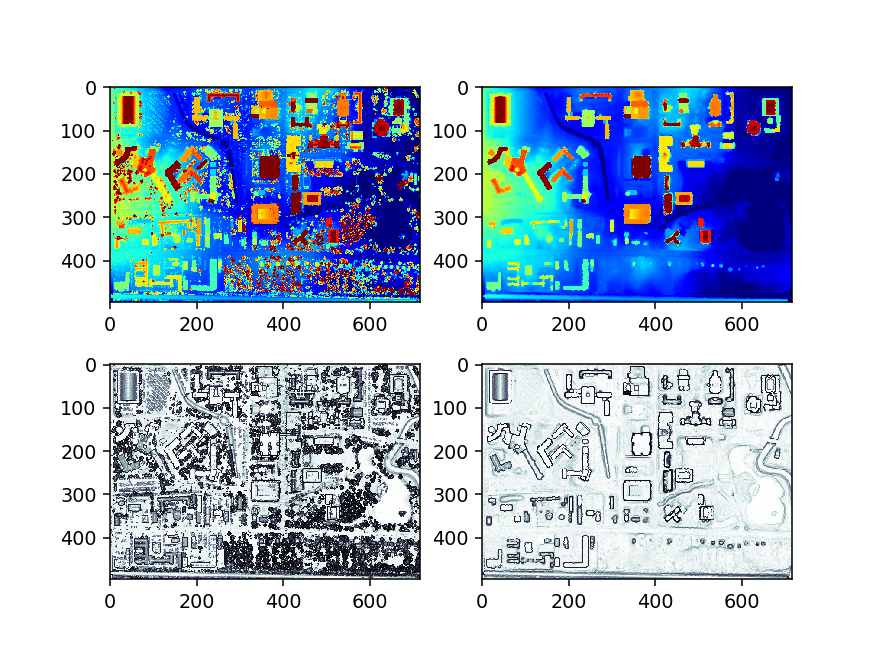

In [5]:
# A basic use-case might look something like this:

# Read in a lidar dataset, and create a DSM for comparison
header, df = neilpy.read_las('../sample_data/DK22_partial.las')
Zmax, Tmax = neilpy.create_dem(df.x,df.y,df.z,cellsize=5,bin_type='max',inpaint=True)

# Use SMRF to filter small objects out of the image
Zsmrf,Tsmrf,obj_cells,obj_array = neilpy.smrf(df.x,df.y,df.z,cellsize=5,windows=3,slope_threshold=.15)

# Create bonemaps of these
Bmax = neilpy.pssm(Zmax,cellsize=5)
Bsmrf = neilpy.pssm(Zsmrf,cellsize=5)

# Save filtered DEM
with rasterio.open('dk22_smrfed.tif', 'w', driver='GTiff', 
                             height=Zsmrf.shape[0], width=Zsmrf.shape[1],
                             count=1, dtype=np.float32, transform=Tsmrf) as src:
    src.write(Zsmrf.astype(np.float32), 1)

# Save bonemap
plt.imsave('dk22_smrfed_bonemap.png',Bsmrf)
neilpy.write_worldfile(Tsmrf,'dk22_smrfed_bonemap.pgw')
    
# Visualize
plt.subplot(221)
plt.imshow(Zmax,aspect='equal',vmin=np.percentile(Zmax,5),vmax=np.percentile(Zmax,95),cmap='jet')
plt.subplot(222)
plt.imshow(Zsmrf,aspect='equal',vmin=np.percentile(Zmax,5),vmax=np.percentile(Zmax,95),cmap='jet')
plt.subplot(223)
plt.imshow(Bmax,aspect='equal')
plt.subplot(224)
plt.imshow(Bsmrf,aspect='equal')
plt.show()

# Testing against the ISPRS Reference Dataset

Prior to its <a target="_blank" href="http://dx.doi.org/10.1016/j.isprsjprs.2012.12.002">publication</a>, SMRF was tested against the <a target="_blank" href="http://www.itc.nl/isprswgIII-3/filtertest/StartPage.htm">ISPRS Dataset for Extracting DEMs from Point Clouds</a>.  The <a target = "_blank" href="http://www.itc.nl/isprswgIII-3/filtertest/Reference.zip">reference dataset</a> includes x,y,z, and identified ground points using both automatic and manual classification.  The original algorithm was developed in Matlab, and so performance metrics given here differ slightly from that implementation, with a slightly better mean performance, but slightly worse median performance than <a target="_blank" href="https://github.com/thomaspingel/smrf-matlab">the Matlab implementation</a>.

Type I Error:   2.00566304861
Type II Error:  4.12498595032
Total Error:    3.09100328095
Cohen's Kappa:  93.8109576375


<IPython.core.display.Javascript object>


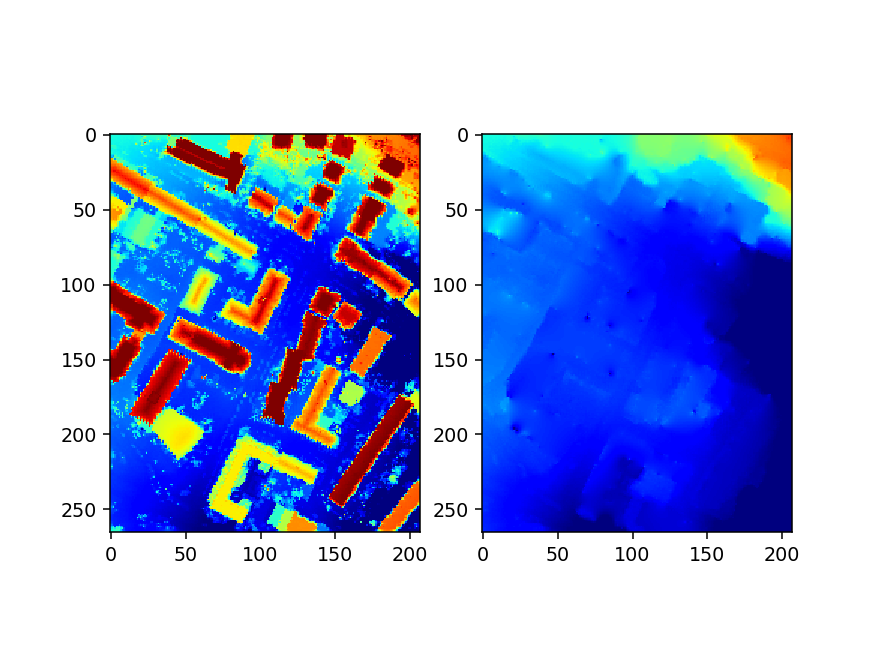

In [4]:
fn = '../sample_data/samp12.txt'
df = pd.read_csv(fn,header=None,names=['x','y','z','g'],delimiter='\t')

cellsize = 1

# Create a DSM for reference to processed set:
Z, T = neilpy.create_dem(df.x,df.y,df.z,cellsize,bin_type='max',inpaint=True)

# Best overall parameters for all samples:
windows = 18
slope_threshold = .15
elevation_threshold = .5
elevation_scaler = 1.25
Zsmrf, Tsmrf, obj_cells, obj_points = neilpy.smrf(df.x,df.y,df.z,cellsize,windows,slope_threshold,
                                                  elevation_threshold,elevation_scaler)

total_error = 1 - np.sum(obj_points == df.g) / len(df)
type_I_error = np.sum((df.g==0) & (obj_points==1)) / np.sum(df.g==1)
type_II_error = np.sum((df.g==1) & (obj_points==0)) / np.sum(df.g==0)
kappa_score = cohen_kappa_score(df.g,obj_points)

print('Type I Error:  ',100 * type_I_error)
print('Type II Error: ',100 * type_II_error)
print('Total Error:   ',100 * total_error)
print('Cohen\'s Kappa: ',100 * kappa_score)

plt.subplot(121)
plt.imshow(Z,cmap='jet',vmin=np.percentile(Z,5),vmax=np.percentile(Z,95))
plt.subplot(122)
plt.imshow(Zsmrf,cmap='jet',vmin=np.percentile(Z,5),vmax=np.percentile(Z,95))
plt.show()